In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import exposure
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt


# Load MNIST dataset using scikit-learn
# SHOULD BE 28x28
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:

def compute_hog_features(image):
    # features, hog_image = hog(image, orientations=8, pixels_per_cell=(2,2), cells_per_block=(1,1), visualize=True)
    feature_descriptor, hog_image = hog(image, orientations=8, pixels_per_cell=(4,4), cells_per_block=(1,1), visualize=True)
    rescaled = exposure.rescale_intensity(hog_image, in_range=(0,64))
    return feature_descriptor, rescaled
    # return rescaled

In [3]:

# Extract features (images) and labels
images, labels = mnist.data, mnist.target.astype(np.uint8)

# Split data to train(80%) and test
train_images, test_images, train_labels, test_labels = train_test_split(np.array(images), np.array(labels), test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)

### Another method using tensorflow
# from tensorflow.keras import datasets
# (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Display number of samples for train and test
print(len(train_images), len(test_images))


11200 2800


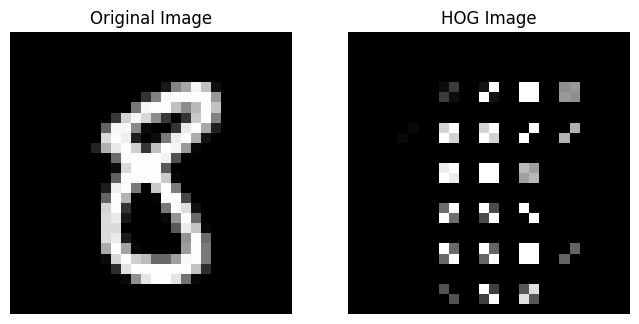

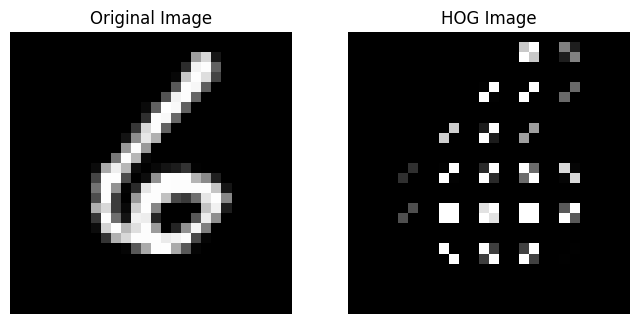

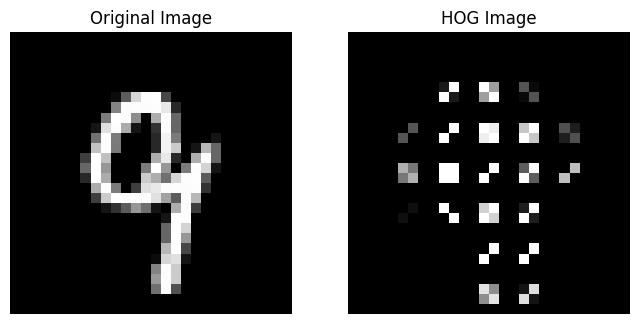

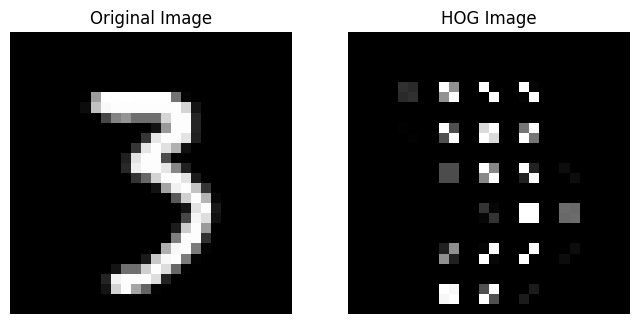

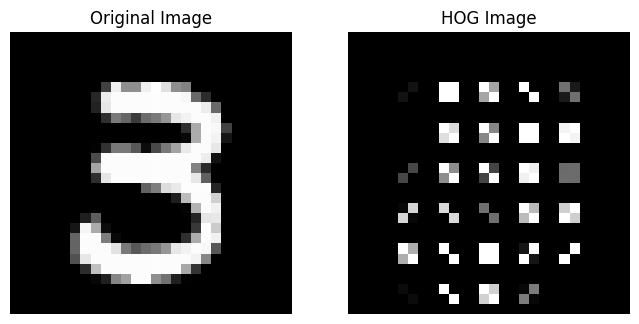

In [4]:
# Take the first 5 images for example and print them before and after HOG
for i in range(5):
    # Take example image as current i index
    example_image = train_images[i].reshape(28,28)

    # Compute HOG features for the example image
    ft, hog_example_image = compute_hog_features(example_image)

    # Plot the original and HOG images side by side
    plt.figure(figsize=(8, 4))

    # # Plot Original image
    plt.subplot(1, 2, 1)
    plt.imshow(example_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot hog version of image
    plt.subplot(1, 2, 2)
    plt.imshow(hog_example_image, cmap='gray')
    plt.title('HOG Image')
    plt.axis('off')

    plt.show()

In [5]:
# TAKES TOO LONG(7 minutes on colab), PLEASE RUN ON COLAB
# Run the HOG feature extraction function on the data set
hog_X_train_descriptors, hog_X_train_images = zip(*[compute_hog_features(image.reshape(28, 28)) for image in train_images])
hog_X_train_images = np.array(hog_X_train_images)
hog_X_train_descriptors = np.array(hog_X_train_descriptors)

hog_X_test_descriptors, hog_X_test_images = zip(*[compute_hog_features(image.reshape(28, 28)) for image in test_images])
hog_X_test_images = np.array(hog_X_test_images)
hog_X_test_descriptors = np.array(hog_X_test_descriptors)

# Print length of both the training and test sets
print(len(hog_X_train_images), len(hog_X_test_images))

11200 2800


In [ ]:
# from SVM import SVM
# from sklearn.metrics import accuracy_score
# svm = SVM()
# hog_X_train_images = hog_X_train_images.reshape(11200, 784)
# hog_X_test_images = hog_X_test_images.reshape(2800, 784)

# svm.fit(hog_X_train_images, train_labels)

# accuracy_score(svm.predict(hog_X_test_images), test_labels)

In [10]:
import sklearn.svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

# Create an instance of the sklearn.svm.OneVsOneClassifier class.
classifier = OneVsOneClassifier(estimator=sklearn.svm.LinearSVC())
hog_X_train_images = hog_X_train_images.reshape((11200, -1))
hog_X_test_images = hog_X_test_images.reshape((2800, -1))
# Fit the classifier to the training data.
classifier.fit(hog_X_train_images, train_labels)

# Make predictions on the test data.
y_pred = classifier.predict(hog_X_test_images)

# Evaluate the model.
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Accuracy: 0.9317857142857143


In [ ]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6)

# Fit the model 
knn.fit(hog_X_train_descriptors, train_labels)

# Make predictions in the test dataset
predictions = knn.predict(hog_X_test_descriptors)

# Print accuracy 
acc = accuracy_score(test_labels , predictions)
print("Accuracy: ", acc)